# U-Net For Image Segmentation

Build a *UNet* for semantic image segmentation. This architecture is a fully convolutional network.

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


We use Oxford Pets - IIT dataset. This contains pet images, their classes, segmentaion masks and head region-of-interest.

In [2]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

#download the datset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

W1104 10:40:20.848905 131926075208832 download_and_prepare.py:46] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset oxford_iiit_pet:3.1.0 from imports: tensorflow_datasets.datasets.oxford_iiit_pet.oxford_iiit_pet_dataset_builder
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 59, in <module>
    app.run(main, flags_parser=_parse_flags)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/download_and_prepa

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteBINU1O/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteBINU1O/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpc4mo_qbltfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

## Prepare dataset
define following functions for preprocessing:
* simple augmentaion by flipping the image
* normalizing the pixel values
* resizing the images
Adjust the segmentation mask's pixel values and the annotation in the dataset mentions that pixels in the segmentation mask are labelled as:

| Label            | Class Name     |
| -------------    | -------------  |
| 1                | foreground     |
| 2                | background     |
| 3                | Not Classified |

<br>
<br>
For convenience, Let's subtract 1 from these values and we will interpret these as {'pet', 'background','outline'}:

| Label | Class Name |
| ----- | ---------- |
| 0     | pet        |
| 1     | background |
| 2     | outline    |


In [5]:
# preprocessing utilities
# does a random flip to the image and mask
def random_flip(input_image,input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


# normalize the input image pixel values from [0,1]
# subtracts 1 from the mask labels to have a range from [0,2]
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function   # decorator, used for creating tensorflow functions, tensorflow functions are way to convert
               # python functions into a format that can be exdcuted efficiently by fensorflow's runtime
def load_image_train(datapoint):
  # resizes, normalizes, and flips the training data
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


Call the utility functions above and prepare train and test sets. The dataset we downloaded clready contains these splits so we will simply accessing the train and test keys of the dataset dictionary.

In [6]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

Utility for data visualization and metrics

In [8]:
# class list of the mask
class_names = ['pet','background','outline']

# utility for display a list of images/masks and overlays a list os IOU and Dice Scores
def display_with_metrics(display_list, iou_list, dice_score_list):

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


# display a list of images/masks
def display(display_list, titles=[], display_string=None):
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()


In [9]:
# utility for display the first image and its mask from a dataset
def show_image_from_dataset(dataset):

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


In [10]:
# Plot a given metrics from the model history
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name], color='blue',label=metric_name)
  plt.plot(model_history.history['val_'+ metric_name], color='green',label='val_'+metric_name)

Take a look at the image and their corresponding mask



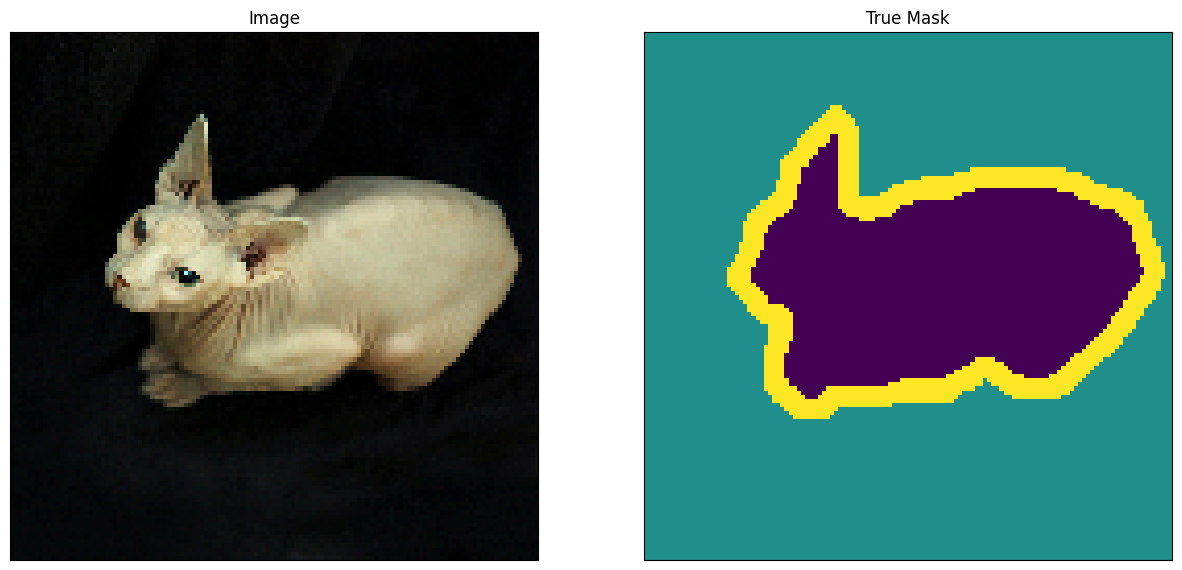

In [11]:
show_image_from_dataset(train)

# Define the model
Here is the architecture of the model:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder(downsampler) and decoder(upsampler) with a bottleneck in between. The gray arrows corresponds to the skip connections that concatenate encoder block outputs to each stage of the decoder.

# Encoder
The encoder will have repeating blocks. These encoder blocks will contain two Conv2D layers activated by Relu, followed by MaxPolling and Droupout layer. Each stage will have incresing numbers of filters and dimensionality of the features will reduce because of poolinglayer.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

The encoder utilities will have three functions:

* `conv2d_block()` - to add two convolution layers and ReLU activations
* `encoder_block()` - to add pooling and dropout to the conv2d blocks. In UNet, we need to save the output of the convolution layers at each block so this function will return two values to take that into account
* `encoder()` - to build the entire encoder. This will return the output of the last encoder block as well as the output of the previous conv blocks.

In [12]:
# Encoder utilities

# adds 2 convolutional layers with parameters passed to it
def conv2d_block(input_tensor,n_filters, kernel_size=3):
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x

# Adds two convolution blocks and then perform down sampling on output of convolutions.
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

# function defines the encoder or downsampling path
def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

# Bottleneck
A bottleneck follows the encoder block is used to extract more features. This does not have pooling layer so the dimensionality remains the same.
Using `conv2d_block()` function.


In [13]:
# This function defines the bottleneck convolutions to extract more features before the upsampling layers.

def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

# Decoder
The decoder which upsamples the features back to the original image size. At each upsampling level, we will take the corresponding encoder block and concatenate it before feeding to the next decoder block.
<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [14]:
# Decoder utility

# define onr decoder block of the UNet
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c

# deine the decoder of the UNet chaining 4 decoder blocks
def decoder(inputs, convs, output_channels):

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

## Puting it all together
Chaining the encoder, bottleneck and decoder. There are three possible output channels and these are: 'pet', 'background','outline'.


In [15]:
OUTPUT_CHANNELS = 3

# defines the UNet by connecting the encoder, bottleneck and decoder
def unet():
  # specify input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  #feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block output to the decoder
  # specify the  number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model = unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

# Compile and train the model
The loss we will be using is `sparse_categorical_crossentropy`. The reason is because the network is trying to assign each pixel a label, just like multi-class prediction.

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 114s 1s/step - loss: 0.9973 - accuracy: 0.5664 - val_loss: 0.8867 - val_accuracy: 0.5729
Epoch 2/10
57/57 [==============================] - 73s 1s/step - loss: 0.8046 - accuracy: 0.6337 - val_loss: 0.7051 - val_accuracy: 0.7205
Epoch 3/10
57/57 [==============================] - 59s 1s/step - loss: 0.6757 - accuracy: 0.7256 - val_loss: 0.6546 - val_accuracy: 0.7334
Epoch 4/10
57/57 [==============================] - 61s 1s/step - loss: 0.6208 - accuracy: 0.7486 - val_loss: 0.6374 - val_accuracy: 0.7296
Epoch 5/10
57/57 [==============================] - 59s 1s/step - loss: 0.5943 - accuracy: 0.7610 - val_loss: 0.5537 - val_accuracy: 0.7833
Epoch 6/10
57/57 [==============================] - 59s 1s/step - loss: 0.5298 - accuracy: 0.7909 - val_loss: 0.5064 - val_accuracy: 0.7992
Epoch 7/10
57/57 [==============================] - 61s 1s/step - loss: 0.4999 - accuracy: 0.8050 - val_loss: 0.4929 - val_accuracy: 0.8031
Epoch 8/10
57/57 [=

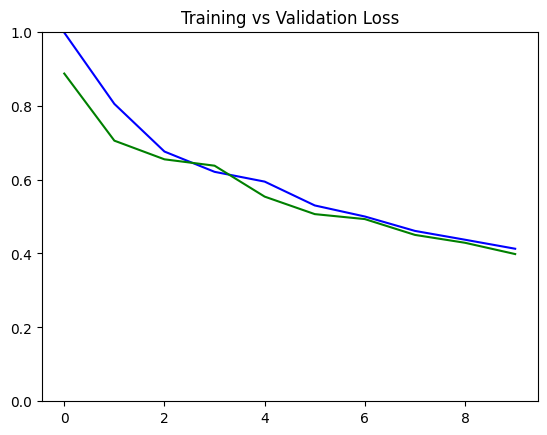

In [18]:
# plot the training and validation curve
plot_metrics("loss", title='Training vs Validation Loss', ylim=1)

# Make Predicitons


In [53]:
# utility for prediction
def get_test_image_and_annotation_arrays():
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


# creates the segmentation mask by getting the channel with the highest probability.
def  create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()

# feed the image to the model and returns the predicted mask
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# Class wise metrics
Utility to compute IOU and Dice Score.

In [54]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001
  for i in range(3):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothing_factor) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)

    dice_score = 2 * ((intersection + smoothing_factor) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [55]:
# getting ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set into the model to get the presicted mask
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)


57/57 [==============================] - 17s 292ms/step


In [56]:
print(results.shape)

(3648, 128, 128, 3)


In [57]:
results = np.argmax(results, axis=3)

In [58]:
print(results.shape)

(3648, 128, 128)


In [59]:
results = results[...,tf.newaxis]

In [60]:
results.shape

(3648, 128, 128, 1)

In [61]:
# compute class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [62]:
# show iou for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10 - len(class_names[idx]) + 2)
  print("{}{}{}".format(class_names[idx], spaces, iou))

pet         0.7097795778176017
background  0.8329774549345663
outline     0.35702151880726396


In [63]:
# show the dice-score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' '*(10 - len(class_names[idx])+2)
  print("{}{}{}".format(class_names[idx],spaces, dice_score))

pet         0.8302585748787225
background  0.9088791056237189
outline     0.5261840197219007


1/1 [==============================] - 0s 19ms/step


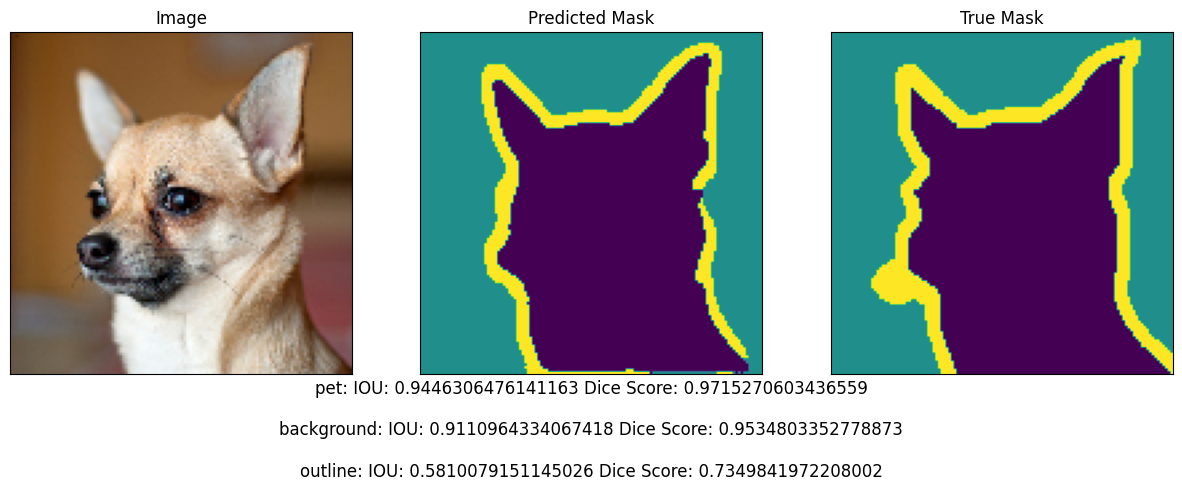

In [67]:
# showing predictions

# Picking an number between 0 to 3647 to pick an imagefrom the dataset
integer_slider = 3645

# get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# overlay metrics with image
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)